# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [2]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [ ]:
# Use this space for any additional import statements you need



In [4]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """

    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens / num_tokens if num_tokens > 0 else 0
    num_characters = sum(len(token) for token in tokens)

    if verbose:
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")

        from collections import Counter
        most_common = Counter(tokens).most_common(num_tokens)
        print("\nMost common tokens:")
        for token, count in most_common:
            print(f"{token}: {count}")

    return [num_tokens, num_unique_tokens, lexical_diversity, num_characters]

    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # modify this function to remove stopwords
    return [token for token in tokens if token not in sw]
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    return [token.lower() for token in whitespace_pattern.split(text) if token]

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [5]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "C:/Users/tysir/Documents/ads-new-lyric/"
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}

In [6]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [7]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [8]:
# read in the lyrics here

lyrics_data = {}

for artist in ["cher", "robyn"]:
    artist_path = os.path.join(data_location, lyrics_folder, artist)
    lyrics_data[artist] = {}

    for filename in os.listdir(artist_path):
        if filename.endswith(".txt"):
            song_title = filename.replace(".txt", "")
            file_path = os.path.join(artist_path, filename)
            with open(file_path, "r", encoding="utf-8") as file:
                lyrics_data[artist][song_title] = file.read()

## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [11]:
lyrics_flat = []

for artist in lyrics_data:
    for title in lyrics_data[artist]:
        lyrics_flat.append({
            "artist": artist,
            "title": title,
            "lyrics": lyrics_data[artist][title]})

lyrics_data = pd.DataFrame(lyrics_flat)

In [12]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len)

In [13]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [14]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
1131221,cher,"#CORPSE: I'VE GOT THEM,, RIGHT WHERE I WANT TH...","[#corpse, ive, got, right, want, 🖤, 🤤, pfp, mi..."
764880,cher,Life in Paradise🌴🌺🍍🍌💕,"[life, paradise🌴🌺🍍🍌💕]"
896496,cher,I want to build my mama a house Ke nyaka GLE63...,"[want, build, mama, house, ke, nyaka, gle63amg..."
745072,cher,Experimental Electronic Rap Duo 👯 The combined...,"[experimental, electronic, rap, duo, 👯, combin..."
632873,cher,победа будет за нами Карабах🇦🇲🇦🇲🙏🏻✊✊✊✊,"[победа, будет, за, нами, карабах🇦🇲🇦🇲🙏🏻✊✊✊✊]"
1594192,cher,"She/Her, thrives on neglect 🦀🌹","[sheher, thrives, neglect, 🦀🌹]"
1664897,cher,"💈😁❤️ husband to @zaC_gaga, animal lover, peace...","[💈😁❤️, husband, zacgaga, animal, lover, peace,..."
1321640,cher,🐘 😁,"[🐘, 😁]"
1256577,cher,Treading water in a sea of red. USC Gamecock b...,"[treading, water, sea, red, usc, gamecock, bas..."
3667692,cher,"1, 2, 3 do the Nicki Minaj blink 👀 | pronouns:...","[1, 2, 3, nicki, minaj, blink, 👀, pronouns, he..."


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: We could keep contractions like "don't" together instead of splitting them up. 

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [25]:
# your code here

print("Cher Lyrics:")
descriptive_stats(lyrics_data[lyrics_data['artist'] == 'cher']['tokens'].explode().tolist())

print("\nRobyn Lyrics:")
descriptive_stats(lyrics_data[lyrics_data['artist'] == 'robyn']['tokens'].explode().tolist())

Cher Lyrics:
There are 35916 tokens in the data.
There are 3703 unique tokens in the data.
There are 172634 characters in the data.
The lexical diversity is 0.103 in the data.

Most common tokens:
love: 1004
im: 513
know: 486
dont: 440
youre: 333
time: 319
baby: 319
see: 308
oh: 306
one: 282
go: 274
like: 271
come: 270
take: 263
heart: 260
never: 253
got: 244
gonna: 222
way: 221
man: 213
cant: 210
say: 202
away: 196
feel: 186
cause: 181
back: 179
make: 178
ive: 177
could: 175
want: 175
night: 171
ill: 170
well: 164
get: 157
theres: 156
believe: 145
right: 140
still: 137
find: 137
let: 135
world: 129
wanna: 129
enough: 129
every: 127
life: 124
day: 124
long: 123
wont: 121
ever: 121
good: 118
walk: 118
need: 114
think: 112
gotta: 108
look: 107
around: 106
home: 105
tell: 103
gone: 100
always: 97
eyes: 97
give: 96
would: 94
really: 94
said: 91
something: 88
without: 88
bang: 88
thats: 84
hold: 84
aint: 83
youll: 83
mind: 83
made: 82
youve: 82
hear: 80
nothing: 79
stay: 78
strong: 77
cry: 

[15227, 2156, 0.14159059565245943, 73787]

Q: what observations do you make about these data? 

A: Cher's lyrics have more words but Robyn's lyrics have more lexical diversity. Cher reuses words more often and Robyn has a more diverse set of vocabulary she uses compared to Cher. Also, they both have the same top four most common tokens but not in the same order. 


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [26]:
# your code here

def get_concentration(tokens):
    total = len(tokens)
    freqs = Counter(tokens)
    return {word: count / total for word, count in freqs.items()}, freqs

def get_top_unique_tokens(target_tokens, comparison_tokens, min_count=5, top_n=10):
    target_conc, target_freq = get_concentration(target_tokens)
    comparison_conc, _ = get_concentration(comparison_tokens)
    
    scores = {}
    for word in target_conc:
        if target_freq[word] >= min_count:
            ratio = target_conc[word] / (comparison_conc.get(word, 1e-9))  # avoid div by zero
            scores[word] = ratio

    return sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]

In [27]:
cher_lyrics = lyrics_data[lyrics_data['artist'] == 'cher']['tokens'].explode().tolist()
robyn_lyrics = lyrics_data[lyrics_data['artist'] == 'robyn']['tokens'].explode().tolist()

cher_twitter = twitter_data[twitter_data['artist'] == 'cher']['tokens'].explode().tolist()
robyn_twitter = twitter_data[twitter_data['artist'] == 'robyn']['tokens'].explode().tolist()

In [28]:
min_count = 5

print("Top 10 unique tokens in Cher lyrics:")
print(get_top_unique_tokens(cher_lyrics, robyn_lyrics, min_count))

print("\nTop 10 unique tokens in Robyn lyrics:")
print(get_top_unique_tokens(robyn_lyrics, cher_lyrics, min_count))

print("\nTop 10 unique tokens in Cher Twitter:")
print(get_top_unique_tokens(cher_twitter, robyn_twitter, min_count))

print("\nTop 10 unique tokens in Robyn Twitter:")
print(get_top_unique_tokens(robyn_twitter, cher_twitter, min_count))

Top 10 unique tokens in Cher lyrics:
[('ooga', 1058024.2788729256), ('blue', 1030181.5346920593), ('darling', 1030181.5346920593), ('womans', 1002338.7905111926), ('small', 1002338.7905111926), ('fernando', 974496.0463303262), ('cryin', 890967.8137877268), ('taxi', 890967.8137877268), ('julie', 863125.0696068604), ('lord', 835282.325425994)]

Top 10 unique tokens in Robyn lyrics:
[('boom', 3612004.991134169), ('u', 2232875.812701123), ('deng', 2101530.1766598807), ('digi', 2101530.1766598807), ('ok', 1970184.5406186376), ('cus', 1838838.9045773952), ('fucking', 1576147.6324949102), ('include', 1247783.542391804), ('psycho', 1247783.542391804), ('indestructible', 1182110.7243711827)]

Top 10 unique tokens in Cher Twitter:
[('resistor', 28842.1733652143), ('gramma', 23978.591189903655), ('#election2016', 19001.902452376482), ('🚫dms', 17418.410581345106), ('#dumptrump', 14986.619493689785), ('grandmom', 14307.980120390625), ('wifemother', 12837.594811575776), ('#indivisible', 12328.615281

Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: Robyn's lyrics seem to be more informal or personal compared to Cher's with words like "boom", "u", "cuz", etc. I noticed on Cher's twitter followers that a lot of the tokens were political and seems to lean toward left ideologies. 

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [29]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [35]:
cher_lyrics_freq = count_words(
    lyrics_data[lyrics_data['artist'] == 'cher'], 
    column='tokens')

robyn_lyrics_freq = count_words(
    lyrics_data[lyrics_data['artist'] == 'robyn'], 
    column='tokens')

cher_twitter_freq = count_words(
    twitter_data[twitter_data['artist'] == 'cher'], 
    column='tokens')

robyn_twitter_freq = count_words(
    twitter_data[twitter_data['artist'] == 'robyn'],
    column='tokens')

In [36]:
for freq_df in [cher_lyrics_freq, robyn_lyrics_freq, cher_twitter_freq, robyn_twitter_freq]:
    freq_df.drop(index='nan', errors='ignore', inplace=True)

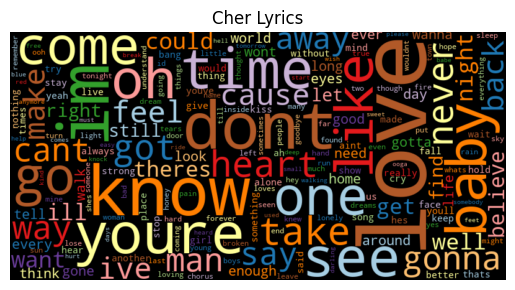

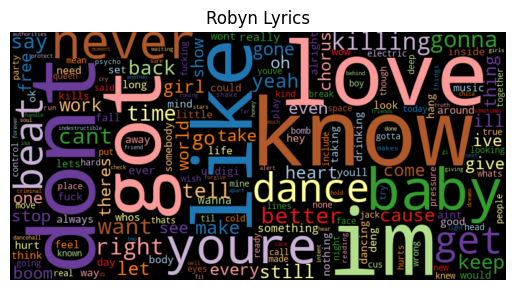

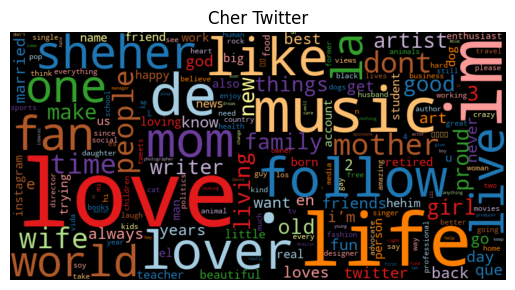

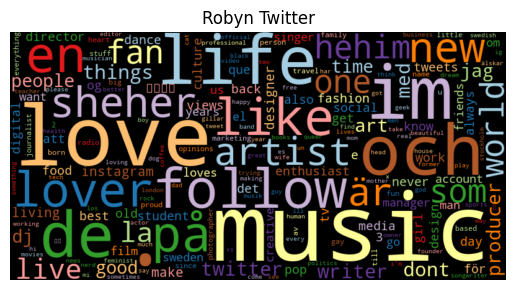

In [37]:
wordcloud(cher_lyrics_freq['freq'], title="Cher Lyrics")
plt.show()

wordcloud(robyn_lyrics_freq['freq'], title="Robyn Lyrics")
plt.show()

wordcloud(cher_twitter_freq['freq'], title="Cher Twitter")
plt.show()

wordcloud(robyn_twitter_freq['freq'], title="Robyn Twitter")
plt.show()

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: A lot of the large words are similar between both artists. Their fans seem to speek similarly on twitter. A lot of their lyrics have the same big words as well. I mentioned this earlier but they have the same top 4 token words so it makes sense they have the same large words in the wordcloud. 